This notebook contains our version of the SSAT and the UAD model. Paper https://drive.google.com/file/d/1Pu2k9vI7YtTnG4M6Bak6QKpDbZV1zIGb/view?usp=sharing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch 
import torch.nn as nn
from torchvision import transforms
from torchvision import models, datasets
from torch.utils.data import DataLoader
import torch.optim as optim

from PIL import Image
import os
import numpy as np
import glob
import matplotlib.pyplot as plt 

from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

Importing Class Variables

In [ ]:
FOLD = "/content/drive/My Drive/classification"
TRAIN_FOLD = os.path.join(FOLD,"train")
TEST_FOLD = os.path.join(FOLD,"test")
CLASSES = 3
CLASS1 = (len([iq for iq in os.scandir(os.path.join(TRAIN_FOLD,"train1"))]))
CLASS2 = (len([iq for iq in os.scandir(os.path.join(TRAIN_FOLD,"train2"))]))
CLASS3 = (len([iq for iq in os.scandir(os.path.join(TRAIN_FOLD,"train3"))]))
print("Numer of Images : \nClass1 : " + str(CLASS1)+ "  Class2 : "+str(CLASS2) +"   Class3 : "+ str(CLASS3))

Numer of Images : 
Class1 : 566  Class2 : 1140   Class3 : 732


The FGSM Attack

The model below has about 98% accuracy in predicting the three class. Now all the adverserial examples will be generated using this model only.

In [ ]:
from keras import models
new_model = models.load_model("/content/drive/My Drive/classification_weighted_full_retrained.h5")

In [ ]:
#implements fgsm for both Keras and Pytorch Model. Initial for generating Adversial Images I used the Keras Model with 98% accuracy
def fgsm(model, X, y, epsilon=0.1,keras = False):
    if(keras):
      X = tf.convert_to_tensor(X,dtype = tf.float32)
      y = tf.convert_to_tensor(y,dtype = tf.float32)
      loss = tf.keras.losses.CategoricalCrossentropy()
      with tf.GradientTape() as tape:
        tape.watch(X)
        prediction = model(X)
        losss = loss(y, prediction)
      gradient = tape.gradient(losss, X)
      signed_grad = tf.sign(gradient)
      return np.asarray(signed_grad * epsilon)
    
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

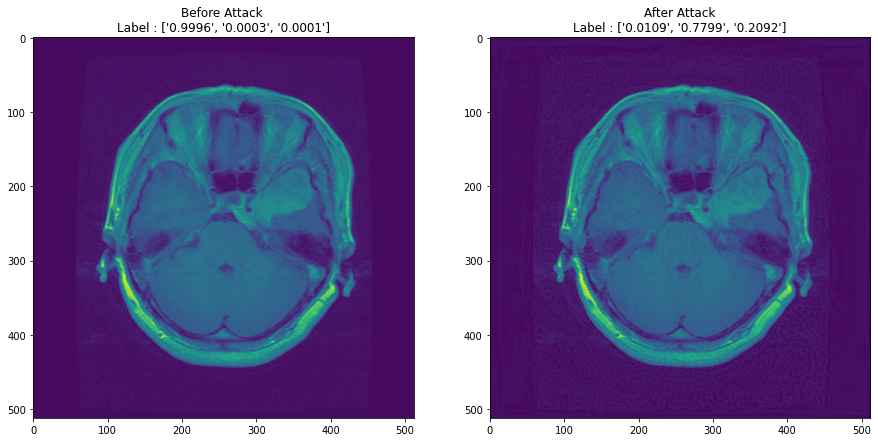

In [ ]:
# Output dimensions of this function are 1, 512,512, for pytorch
def getImage(full_loc):
  img = Image.open(full_loc)
  trans1 = transforms.ToTensor()
  X = trans1(img)
  return X

# This function prepares it for the Keras Model Input
def transformForKeras(path):
  imgg = []
  img = img_to_array(load_img(path))
  img = img/255
  # img = np.repeat(img, 3, 2)
  imgg.append(img)
  return np.asarray(imgg)


def showAttack(model, path, epsilon = None):
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
  img = transformForKeras(path)
  ax1.imshow(img[0,:,:,0])
  ax1.set_title('Before Attack \nLabel : ' +str([ '%.4f' % elem for elem in model.predict(img)[0] ]))
  ep = 0
  if(epsilon):
    ep = fgsm(model,img,np.asarray([[1,0,0]]),epsilon,keras = True)
  else:
    fgsm(model,img,np.asarray([[1,0,0]]),keras = True)
  nimg = img + ep
  ax2.imshow(nimg[0,:,:,0])
  ax2.set_title('After Attack\nLabel : ' +str([ '%.4f' % elem for elem in model.predict(nimg)[0] ]))
  plt.plot()

path = os.path.join(TRAIN_FOLD,"train1/1.jpg")
showAttack(new_model,path,0.01)

Implementing the SSAT Model and taking the VGG16 Model

In [ ]:
from torchvision import models, datasets
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
def modelM():
  model = models.vgg16(pretrained= True)
  n_inputs = model.classifier[0].in_features
  model.classifier = nn.Sequential(nn.Linear(n_inputs,512),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(512,CLASSES)
                                      )
  #print(model)
  return model
model = modelM()

if torch.cuda.is_available():
    model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
weights = torch.FloatTensor([1.435,0.7128,1.1102]).cuda()
lossss = nn.CrossEntropyLoss(weights)


def epoch_adversarial(loader, model, attack, opt=None):
    total_loss, correct_pred = 0.,0.
    iterations = int(len(loader.dataset)/loader.batch_size)
    i = 1
    for X,y in loader:
      X,y = X.to(device), y.to(device)
      delta = attack(model, X, y,0.01)
      yp = model(X+delta)
      yptemp = model(X)
      yp = torch.cat((yptemp,yp), dim = 0)
      y = torch.cat((y,y),dim = 0)
      loss = lossss(yp,y)
      if(opt):
        if(i%20==0):
          print (i,"/",iterations,":  ", loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
      i+=1
      correct_pred += (yp.max(dim=1)[1] == y).sum().item()
      total_loss += loss.item() * X.shape[0]
    return correct_pred / (2*len(loader.dataset)), total_loss / len(loader.dataset)

def epoch(loader, model, opt=None):
    total_loss, correct_pred = 0.,0.
    iterations = int(len(loader.dataset)/loader.batch_size)
    i = 1
    for X,y in loader:
      X,y = X.to(device), y.to(device)
      yp = model(X)
      loss = lossss(yp,y)
      if(opt):
        if(i%20==0):
          print (i,"/",iterations,":  ", loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
      i+=1
      correct_pred += (yp.max(dim=1)[1] == y).sum().item()
      total_loss += loss.item() * X.shape[0]
    return correct_pred / len(loader.dataset), total_loss / len(loader.dataset)


In [ ]:
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))

])

dfTrain = datasets.ImageFolder(root = TRAIN_FOLD, transform=transform)
TrainLoader = DataLoader(dfTrain, batch_size = BATCH_SIZE, shuffle = True)
dfTest = datasets.ImageFolder(root = TEST_FOLD, transform=transform)
TestLoader = DataLoader(dfTest, batch_size = BATCH_SIZE, shuffle = False)


In [ ]:
EPOCHS = 20
LEARNING_RATE = 1e-3

TrainAcc , TestAcc, TrainLoss, TestLoss= [],[],[],[]

opt = optim.SGD(model.parameters(), lr=LEARNING_RATE)
for t in range(1,EPOCHS+1):  
  print ("Epoch", t, ":")
  adv_accuracy, adv_loss = epoch_adversarial(TrainLoader, model, fgsm,opt)
  print("\nOverall Loss : ",adv_loss,"      Overall Accuracy : ",adv_accuracy*100,"%\n")
  print("On validation Set")
  TrainAcc.append(adv_accuracy)
  TrainLoss.append(adv_loss)
  adv_accuracy2, adv_loss2 = epoch(TestLoader, model)
  print("Overall Loss : ",adv_loss2,"      Overall Accuracy : ",adv_accuracy2*100,"%\n")
  TestAcc.append(adv_accuracy2)
  TestLoss.append(adv_loss2)

Epoch 1 :
20 / 76 :   1.009428858757019
40 / 76 :   0.9309710264205933
60 / 76 :   0.9200122952461243

Overall Loss :  0.9981031423225277       Overall Accuracy :  49.159146841673504 %

On validation Set
Overall Loss :  0.6075147645953439       Overall Accuracy :  81.50572831423895 %

Epoch 2 :
20 / 76 :   0.934382975101471
40 / 76 :   0.788579523563385
60 / 76 :   0.8205562233924866

Overall Loss :  0.8686872600922338       Overall Accuracy :  58.44954881050041 %

On validation Set
Overall Loss :  0.5067726174055457       Overall Accuracy :  85.27004909983633 %

Epoch 3 :
20 / 76 :   0.784579336643219
40 / 76 :   0.8354944586753845
60 / 76 :   0.7546562552452087

Overall Loss :  0.7953844993108604       Overall Accuracy :  62.07957342083675 %

On validation Set
Overall Loss :  0.44085306610832825       Overall Accuracy :  81.34206219312603 %

Epoch 4 :
20 / 76 :   0.8687015175819397
40 / 76 :   0.639301598072052
60 / 76 :   0.6688270568847656

Overall Loss :  0.7394116509635493       

This model is the one trained for 20 epochs and the following are the stats

For the **Training Set** :

**Accuracy** : 87.3%  **Loss** : 0.2877

For the **Test Set** :

**Accuracy** :89.6%  **Loss** : 0.2148

In [ ]:
# torch.save(model.state_dict(), "/content/drive/My Drive/SSATOnlyJan.pt")

Trainig for some more epochs with a reduced learning rate

In [ ]:
opt = optim.SGD(model.parameters(), lr=1e-4)
for t in range(1,10+1):  
  print ("Epoch", t, ":")
  adv_accuracy, adv_loss = epoch_adversarial(TrainLoader, model, fgsm,opt)
  print("\nOverall Loss : ",adv_loss,"      Overall Accuracy : ",adv_accuracy*100,"%\n")
  print("On validation Set")
  TrainAcc.append(adv_accuracy)
  TrainLoss.append(adv_loss)
  adv_accuracy2, adv_loss2 = epoch(TestLoader, model)
  print("Overall Loss : ",adv_loss2,"      Overall Accuracy : ",adv_accuracy2*100,"%\n")
  TestAcc.append(adv_accuracy2)
  TestLoss.append(adv_loss2)

Epoch 1 :
20 / 76 :   0.15838417410850525
40 / 76 :   0.1782667189836502
60 / 76 :   0.29467007517814636

Overall Loss :  0.2621254982079904       Overall Accuracy :  88.96636587366694 %

On validation Set
Overall Loss :  0.16705631746517252       Overall Accuracy :  93.12602291325696 %

Epoch 2 :
20 / 76 :   0.18351542949676514
40 / 76 :   0.2405371516942978
60 / 76 :   0.31699395179748535

Overall Loss :  0.23784221378113032       Overall Accuracy :  89.54060705496309 %

On validation Set
Overall Loss :  0.158993612915436       Overall Accuracy :  93.9443535188216 %

Epoch 3 :
20 / 76 :   0.21124468743801117
40 / 76 :   0.18275342881679535
60 / 76 :   0.3321923017501831

Overall Loss :  0.23841678795509402       Overall Accuracy :  89.31501230516817 %

On validation Set
Overall Loss :  0.15623484653574696       Overall Accuracy :  92.7986906710311 %

Epoch 4 :
20 / 76 :   0.18447528779506683
40 / 76 :   0.20537133514881134
60 / 76 :   0.1511811465024948

Overall Loss :  0.23105801716

This model is the continuation of the previous model and has been trained for 30 epochs. 

For the **Training** **Set** :

**Accuracy** : 90% **Loss** :  0.2144

For the **Test Set** :

**Accuracy** : 94% **Loss** : 0.1450

In [ ]:
# torch.save(model.state_dict(), "/content/drive/My Drive/SSATOnlyJan2.pt")

The plot of Adverserial Training after 30 epochs

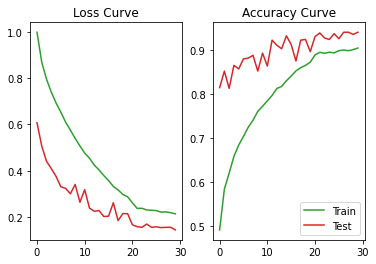

In [ ]:
# Accuracy and loss curves
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Loss Curve')
l1, = ax1.plot(TrainLoss,'tab:green')
l2, = ax1.plot(TestLoss,'tab:red')
ax2.set_title('Accuracy Curve')
ax2.plot(TrainAcc,'tab:green')
ax2.plot(TestAcc,'tab:red')
plt.legend([l1,l2],["Train","Test"])

Training the normal model for the sake of comparison with the one that of the one trained Adverserial model

In [ ]:
modelSimple = modelM()
if torch.cuda.is_available():
    modelSimple.cuda()

In [ ]:
EPOCHS = 12
LEARNING_RATE = 1e-3

TrainAcc2 , TestAcc2, TrainLoss2, TestLoss2= [],[],[],[]

opt = optim.SGD(modelSimple.parameters(), lr=LEARNING_RATE)
for t in range(1,EPOCHS+1):  
  print ("Epoch", t, ":")
  adv_accuracy, adv_loss = epoch(TrainLoader, modelSimple,opt)
  print("\nOverall Loss : ",adv_loss,"      Overall Accuracy : ",adv_accuracy*100,"%\n")
  print("On validation Set")
  TrainAcc2.append(adv_accuracy)
  TrainLoss2.append(adv_loss)
  adv_accuracy2, adv_loss2 = epoch(TestLoader, modelSimple)
  print("Overall Loss : ",adv_loss2,"      Overall Accuracy : ",adv_accuracy2*100,"%\n")
  TestAcc2.append(adv_accuracy2)
  TestLoss2.append(adv_loss2)

Epoch 1 :
20 / 76 :   0.7992499470710754
40 / 76 :   0.6645668745040894
60 / 76 :   0.3865971863269806

Overall Loss :  0.7158353625016686       Overall Accuracy :  72.55947497949138 %

On validation Set
Overall Loss :  0.44707019367970147       Overall Accuracy :  83.9607201309329 %

Epoch 2 :
20 / 76 :   0.34427163004875183
40 / 76 :   0.25342950224876404
60 / 76 :   0.45952123403549194

Overall Loss :  0.37063921551610524       Overall Accuracy :  86.38228055783429 %

On validation Set
Overall Loss :  0.46891283809699713       Overall Accuracy :  78.39607201309329 %

Epoch 3 :
20 / 76 :   0.3572372794151306
40 / 76 :   0.21332398056983948
60 / 76 :   0.39152655005455017

Overall Loss :  0.2794473242378313       Overall Accuracy :  88.96636587366694 %

On validation Set
Overall Loss :  0.272720436295784       Overall Accuracy :  90.67103109656301 %

Epoch 4 :
20 / 76 :   0.09189207851886749
40 / 76 :   0.26424843072891235
60 / 76 :   0.1696006804704666

Overall Loss :  0.213460375066

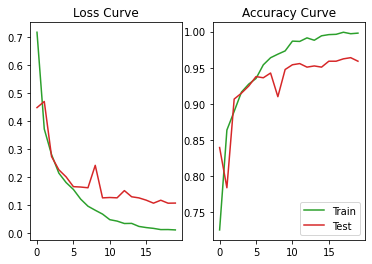

In [ ]:
# Accuracy and loss curves
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Loss Curve')
l1, = ax1.plot(TrainLoss2,'tab:green')
l2, = ax1.plot(TestLoss2,'tab:red')
ax2.set_title('Accuracy Curve')
ax2.plot(TrainAcc2,'tab:green')
ax2.plot(TestAcc2,'tab:red')
plt.legend([l1,l2],["Train","Test"])

Testing both the models in terms of Adversial Images. For that first I'll have to generate adverserial Images

In [ ]:
def TestAdverserial(loader, model,attack,perturb):
    correct_pred = 0.
    iterations = int(len(loader.dataset)/loader.batch_size)
    i = 1
    for X,y in loader:
      X,y = X.to(device), y.to(device)
      delta = attack(model, X, y,perturb)
      yp = model(X+delta)
      i+=1
      if(i%10==0):
        print(str(i)+"images done")
      correct_pred += (yp.max(dim=1)[1] == y).sum().item()
    return correct_pred / len(loader.dataset)


For 2 perturbation Rate, it can be seen that the Adverserially Trained Model works much better

In [ ]:
dfTest = datasets.ImageFolder(root = TEST_FOLD, transform=transform)
TestLoader = DataLoader(dfTest, batch_size = 2, shuffle = False)
AdvModelAcc = TestAdverserial(TestLoader,model,fgsm,0.01)

In [ ]:
AdvModelAcc

0.7479541734860884

In [ ]:
SimModelAcc = TestAdverserial(TestLoader,modelSimple,fgsm,0.01)

In [ ]:
SimModelAcc

0.03927986906710311

In [ ]:
AdvModelAcc2 = TestAdverserial(TestLoader,model,fgsm,0.005)
print(AdvModelAcc2)

0.8477905073649754


In [ ]:
SimModelAcc2 = TestAdverserial(TestLoader,modelSimple,fgsm,0.005)
print(SimModelAcc2)

0.16202945990180032


Attack of PGD Results

In [ ]:
def pgd(model, X, y, epsilon=0.05, alpha=1e4, num_iter=10):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
dfTest = datasets.ImageFolder(root = TEST_FOLD, transform=transform)
TestLoader = DataLoader(dfTest, batch_size = 2, shuffle = False)
AdvModelAcc = TestAdverserial(TestLoader,ModelSimple,pgd,0.005)
print(AdvModelAcc)

10images done
20images done
30images done
40images done
50images done
60images done
70images done
80images done
90images done
100images done
110images done
120images done
130images done
140images done
150images done
160images done
170images done
180images done
190images done
200images done
210images done
220images done
230images done
240images done
250images done
260images done
270images done
280images done
290images done
300images done
0.839607201309329


In [ ]:
# AdvModelAcc = TestAdverserial(TestLoader,ModelSimple,pgd,0.005)
# print(AdvModelAcc)

**Implementing the UAD on the Models**

Day 2: Loading and Implementing the UAD Model. Before that loading the models that I trained yesterday

In [ ]:
ModelSimple = modelM()
if torch.cuda.is_available():
    ModelSimple.cuda()

ModelSimple.load_state_dict(torch.load("/content/drive/My Drive/SSATOnlyJan2.pt"))

<All keys matched successfully>

In [ ]:
ModelSimple.eval()
TestLoader = DataLoader(dfTest, batch_size = 1, shuffle = False)
imgg,y = iter(TestLoader).next()
imgg = imgg.to(device)
print(ModelSimple(imgg))
# This Gives the result of the second last layer
print((ModelSimple.classifier[:4](torch.flatten(ModelSimple.avgpool(ModelSimple.features(imgg)),1))))


tensor([[ 5.8517,  3.7875, -6.9939]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 5.8517,  3.7875, -6.9939]], device='cuda:0', grad_fn=<AddmmBackward>)


In [ ]:
#Getting the second last layer for all the clean test Images
def getPenul(model,loader):
  # Assuming that the Batch Size is 1
  PenulLayer = []
  i = 0
  for X,y in loader:
    X = X.to(device)
    SecondLast = (model.classifier[:3](torch.flatten(model.avgpool(model.features(X)),1)))
    PenulLayer.append(np.squeeze(SecondLast.cpu().detach().numpy()))
    i+=1
    if(i%100==0):
      print(str(i) + " images done")
  return np.asarray(PenulLayer)




In [ ]:
TrainLoader = DataLoader(dfTrain, batch_size = 1, shuffle = False)
AllImgLastLayer = getPenul(ModelSimple,TrainLoader)
np.shape(AllImgLastLayer)

100 images done
200 images done
300 images done
400 images done
500 images done
600 images done
700 images done
800 images done
900 images done
1000 images done
1100 images done
1200 images done
1300 images done
1400 images done
1500 images done
1600 images done
1700 images done
1800 images done
1900 images done
2000 images done
2100 images done
2200 images done
2300 images done
2400 images done


(2438, 512)

In [ ]:
from sklearn import mixture
clf = mixture.GaussianMixture(n_components=3, covariance_type='full')

In [ ]:
clf.fit(AllImgLastLayer)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
clf.means_

array([[0.95235619, 0.11389682, 0.18059995, ..., 0.16634527, 0.21070321,
        0.33390383],
       [0.49467827, 1.08173943, 0.01773261, ..., 1.28381851, 1.49996841,
        0.25922387],
       [0.09819596, 0.29738702, 4.56100036, ..., 0.23349473, 2.27469802,
        0.62075966]])

In [ ]:
imgg,y = iter(TestLoader).next()
imgg = imgg.to(device)


In [ ]:
a = (ModelSimple.classifier[:3](torch.flatten(model.avgpool(model.features(imgg)),1)))

a = (a.cpu().detach().numpy())
print(np.shape(a))
print(type(a))

(1, 512)
<class 'numpy.ndarray'>


In [ ]:
i = 0
for imgg,y in TestLoader:
  print(y)
  imgg,y = imgg.to(device),y.to(device)
  delta = fgsm(ModelSimple,imgg,y)
  a = (ModelSimple.classifier[:3](torch.flatten(model.avgpool(model.features(imgg+delta)),1)))

  a = (a.cpu().detach().numpy())
  
  print(clf.predict_proba(a))
  i+=1
  if(i==20):
    break

tensor([0])
[[1. 0. 0.]]
tensor([0])
[[1.00000000e+00 1.28474976e-91 0.00000000e+00]]
tensor([0])
[[1. 0. 0.]]
tensor([0])
[[2.78442282e-119 0.00000000e+000 1.00000000e+000]]
tensor([0])
[[1.00000000e+000 0.00000000e+000 9.36606214e-247]]
tensor([0])
[[1. 0. 0.]]
tensor([0])
[[1.00000000e+000 0.00000000e+000 8.12208227e-266]]
tensor([0])
[[1.71340313e-94 1.00000000e+00 0.00000000e+00]]
tensor([0])
[[0.00124528 0.99875472 0.        ]]
tensor([0])
[[1. 0. 0.]]
tensor([0])
[[1. 0. 0.]]
tensor([0])
[[1.00000000e+000 0.00000000e+000 7.24415843e-313]]
tensor([0])
[[1.00000000e+000 1.74414189e-290 4.22304095e-054]]
tensor([0])
[[1. 0. 0.]]
tensor([0])
[[1.00000000e+000 8.85660834e-149 0.00000000e+000]]
tensor([0])
[[1.00000000e+00 2.38754777e-48 0.00000000e+00]]
tensor([0])
[[1.0000000e+00 3.4532413e-57 0.0000000e+00]]
tensor([0])
[[1. 0. 0.]]
tensor([0])
[[3.11007743e-44 1.00000000e+00 0.00000000e+00]]
tensor([0])
[[0. 1. 0.]]


In [ ]:
if(clf.predict_proba(a)[0][0]<1):
  print("Yo")
else:
  print("No")

No


In [ ]:
clf.score(a)

-287.4513109564683